#   0. **Загрузка и импорт необходимых библиотек**

In [ ]:
!pip install sweetviz

In [ ]:
!pip install category_encoders

In [ ]:
# анализ данных и их обработка
import pandas as pd
# для математических вычислений
import numpy as np

# для предварительного EDA
import sweetviz as sv

# для визуализации
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

from scipy.stats import normaltest # тест Д'Агостино
from sklearn.feature_selection import f_classif #ANOVA
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn import preprocessing # для нормализации

# для кодирования признаков
import category_encoders as ce

# для обработки отзывов
import nltk
from nltk.sentiment.vader import  SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# инструмент для разбивки  
from sklearn.model_selection import train_test_split 

# инструмент для создания и обучения модели  
from sklearn.ensemble import RandomForestRegressor 
# инструменты для оценки точности модели 
from sklearn import metrics  
  

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# фиксируем RANDOM_SEED для воспроизводимости эксперементов
RANDOM_SEED=42

In [ ]:
#фиксируем версии пакетов
!pip freeze > requirements.txt

# 1. **Создаем DataFrame**

In [ ]:
data_hotels = pd.read_csv('data/hotels.csv')

In [ ]:
hotels = data_hotels.copy()
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


# 2. **Знакомство с данными**

2.1 Для первого знакомства с данными проведем предварительный анализ данных с помощью библиотеки Sweetviz

In [ ]:
report = sv.analyze(hotels)
report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


[Ссылка на отчет SWEETVIZ_REPORT](https://drive.google.com/file/d/1-bUshToF4ApPUTYD6DwpGJcG3f7ZUJtH/view?usp=sharing)

2.2 Общая информация о данных

In [ ]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

2.3 Количество уникальных значений

In [ ]:
hotels.nunique(dropna=True)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             225
negative_review                               248828
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               311737
review_total_positive_word_counts                354
total_number_of_reviews_reviewer_has_given       194
reviewer_score                                    37
tags                                           47135
days_since_review                                731
lat                                             1472
lng                                             1472
dtype: int64

2.4 Основная статистическая информация числовых признаков

In [ ]:
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


2.5 Построим матрицу корреляций числовых признаков

Text(0.5, 1.0, 'Тепловая карта корреляций числовых признаков')

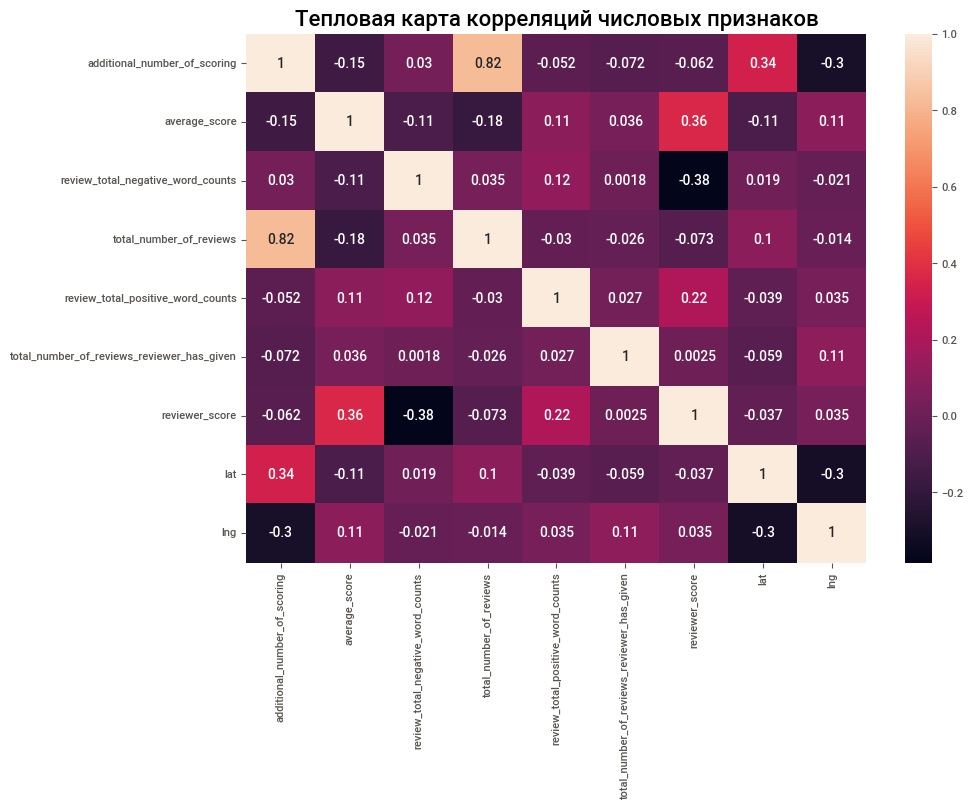

In [ ]:
plt.rcParams['figure.figsize']=(10,7)
ax=sns.heatmap(hotels.corr(), annot = True)
ax.set_title('Тепловая карта корреляций числовых признаков', fontsize=16)

2.6 Графики распределения  числовых признаков для визуальной оценки характера распределения числовых данных

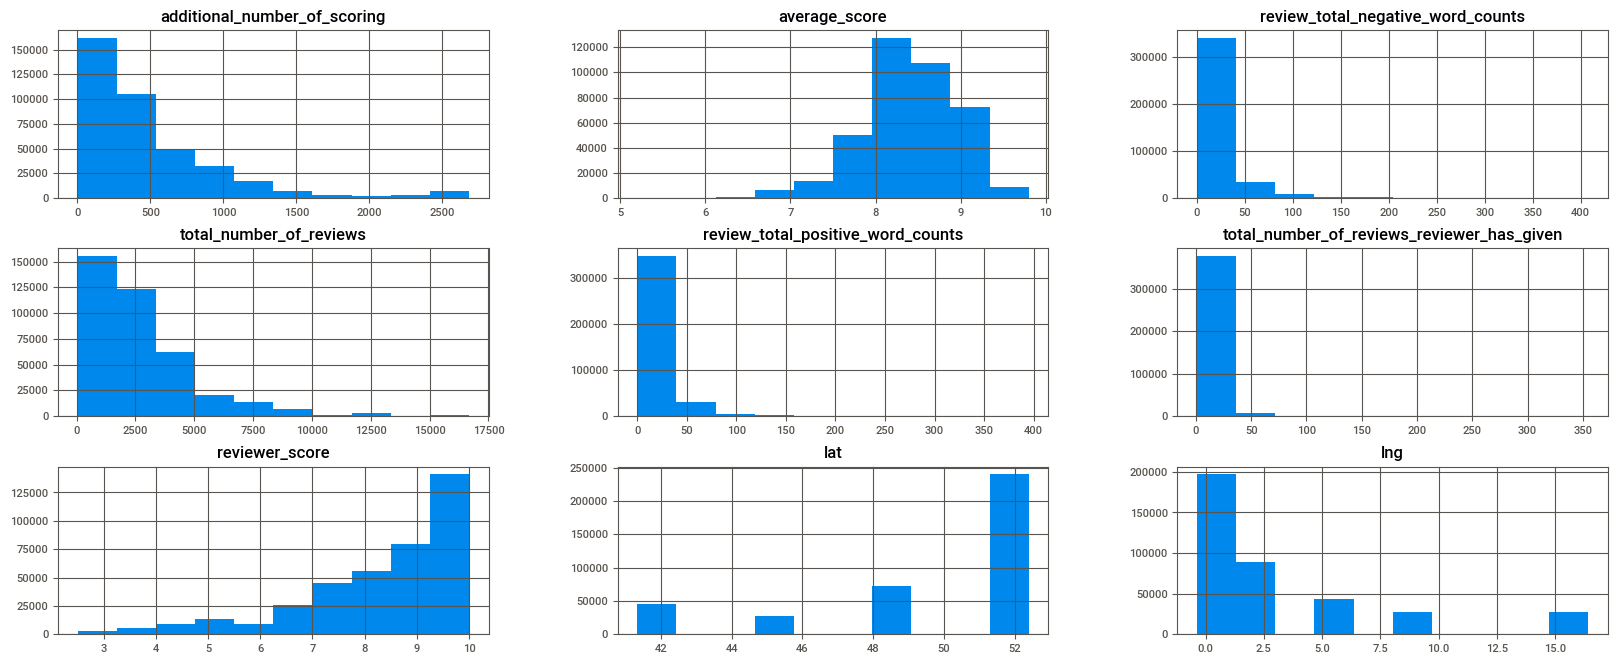

In [ ]:
fig=hotels.hist(figsize=(20, 8));

Как видно из гистограмм данные распределены ненормально.

# 3. **Преобразование данных**


## 3.1 Заполнение пропусков

Пропуски имеют место в столбцах географические ширина (***lat***) и долгота (***lng***) отеля. 
Эти признаки очень сильно зависят от города отеля, поэтому заполним пропуски медианным значением для каждого города.
Для этого выделим город отеля из признака ***hotel_address***.

Согласно предварительному анализу данных всех адресов (кроме Великобритании), город указан в предпоследнем слове, а для Соединного Королевства - перед индексом (в 5 слове с конца)

*Примечание:* выделять из признака hotel_address, еще и страну не имеет смысла, т.к. каждая страна представлена только одним городом.


In [ ]:
def get_city(address):
    """Функция для выделения города из адреса отеля

    Args:
        address: строка с адрессом.

    Returns:
        city: новая строка - город отеля
        
    """
    # разбиваем строку по пробелу:
    address_list=address.split()
    # создаем категории нового признака
    if address_list[-1]=='Kingdom':
        city=address_list[-5]
    else:
        city=address_list[-2]
    return city

# создаем признак 'city_hotel' 
hotels['city_hotel']=hotels['hotel_address'].apply(get_city)

Text(0.5, 1.0, 'Города отелей')

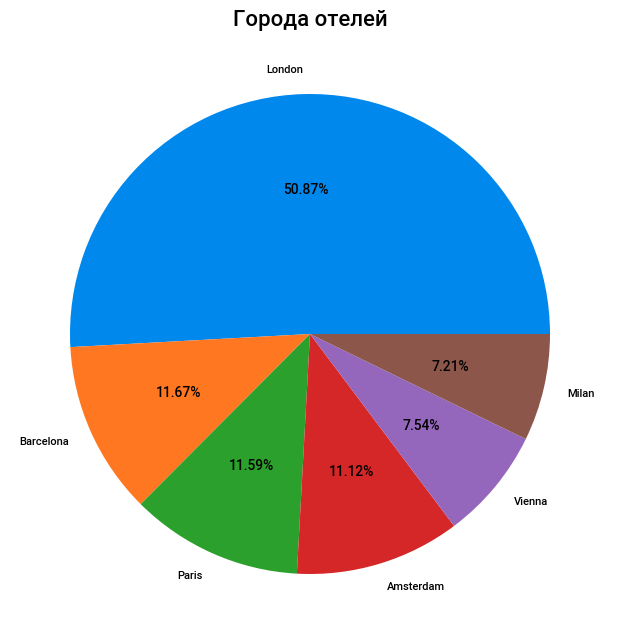

In [ ]:
city=hotels['city_hotel'].value_counts()
# визуализируем частоту городов отелей
fig = plt.figure(figsize=(6, 6))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    city,
    autopct='%.2f%%',
    labels=city.index,
);
axes.set_title('Города отелей', fontsize=16)

In [ ]:
#заполняем пропуски в 'lng' и 'lat' медианой, сгруппированной по городам отелей
name_lng='lng'
hotels.loc[hotels[name_lng].isnull(), name_lng]=hotels.groupby(
    by='city_hotel')[name_lng].transform('median')
name_lat='lat'
hotels.loc[hotels[name_lat].isnull(), name_lat]=hotels.groupby(
    by='city_hotel')[name_lat].transform('median')

In [ ]:
print(f'Количество пропусков по столбцам \n{hotels.isnull().sum()}')

Количество пропусков по столбцам 
hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
city_hotel                                    0
dtype: int64


## 3.2 Числовые признаки
Отмечаем, что данные распределены ненормально - применяем непараметрические тесты.



### 3.2.1 Мультиколлинеарность признаков
Исходя, из матрицы корреляции (корреляция Пирсона) построенной выше признаки ***additional_number_of_scoring  и total_number_of_reviews***, мультиколлиниарны. Проверим эту гипотезу также с помощью корреляции Спирмена, т.к. данные распределены ненормально и корреляция Пирсона может давать ошибку

Text(0.5, 1.0, 'Тепловая карта корреляций Спирмена')

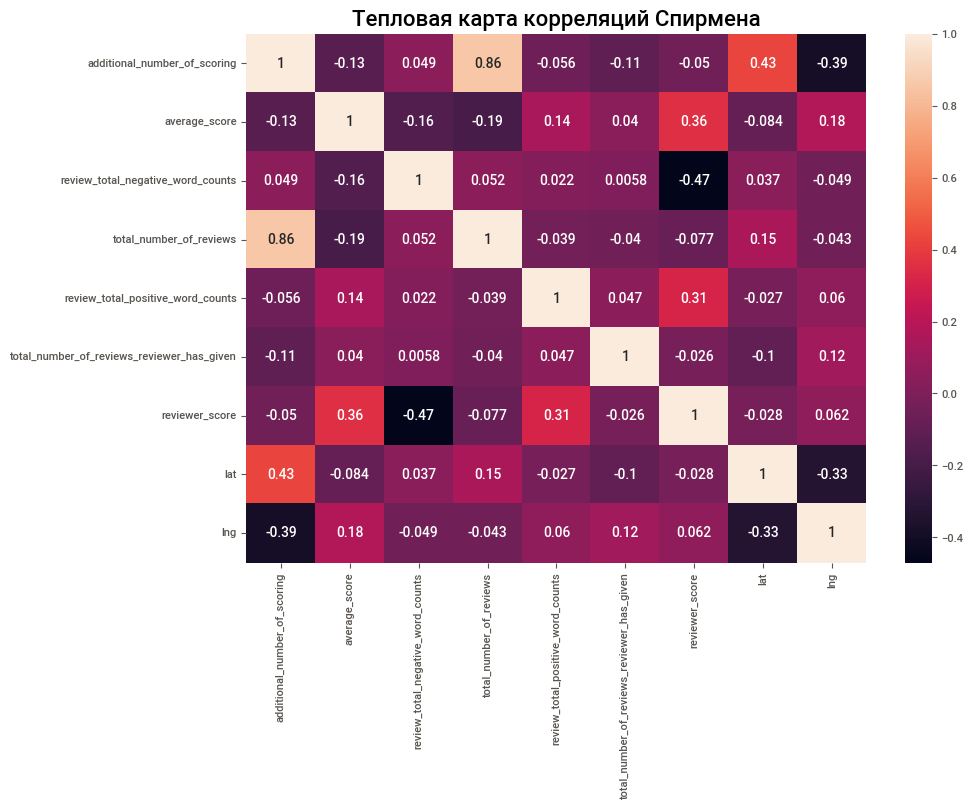

In [ ]:
plt.rcParams['figure.figsize']=(10,7)
ax=sns.heatmap(hotels.corr(method='spearman'), annot = True)
ax.set_title('Тепловая карта корреляций Спирмена', fontsize=16)

Корреляция Спирмена также показала мультиколлинеарность признаков additional_number_of_scoring и total_number_of_reviews. Удалим один из них.

In [ ]:
hotels.drop('additional_number_of_scoring', axis = 1, inplace=True)

### 3.2.2 Значимость признаков для целевого признака
 Разделим числовые признаки на непрерывные и категориальные и оценим их значимость для целевого признака ***(reviewer_score)***

In [ ]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given']

# категориальные признаки
cat_cols = ['average_score', 'days_since_review', 'lat', 'lng']

С помощью метода ANOVA оценим значимость непрерывных признаков для 
целевого признака

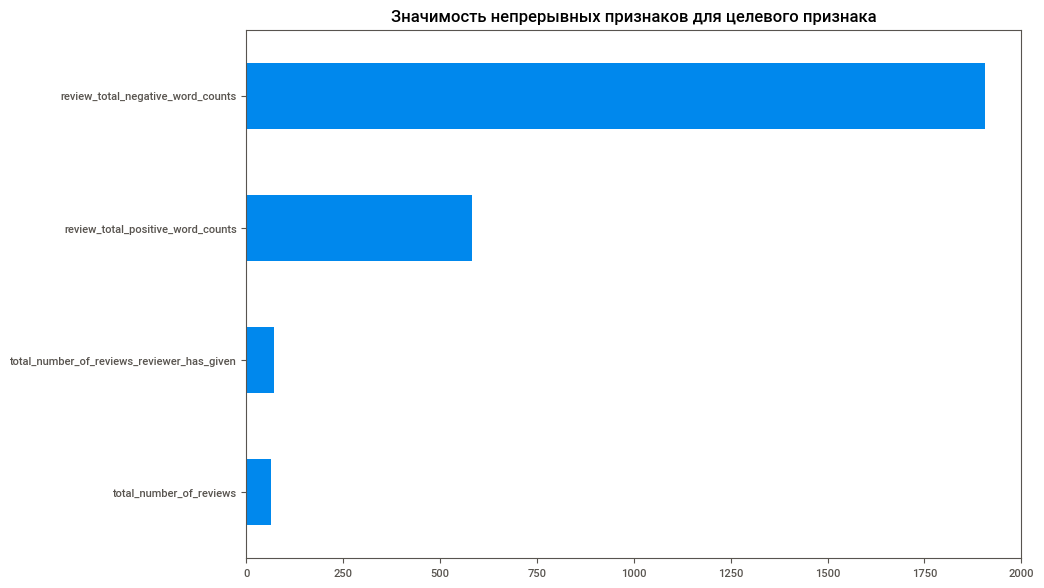

In [ ]:
imp_num = pd.Series(f_classif(hotels[num_cols], hotels['reviewer_score'])[0], 
                    index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', 
             title='Значимость непрерывных признаков для целевого признака',
             figsize=(10,7))

С помощью метода хи-квадрат оценим значимость категориальных признаков для целевого признака

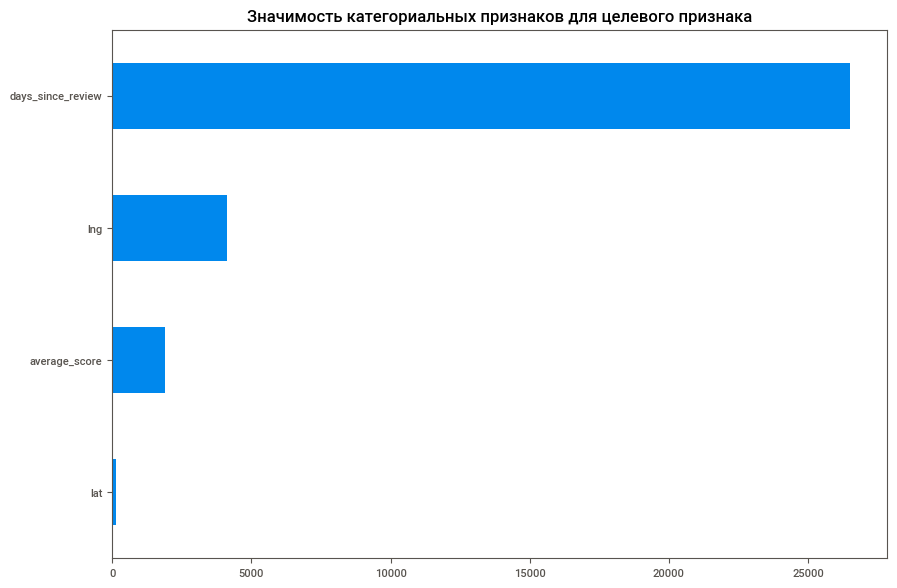

In [ ]:
# прибавим 1 к данным 'lng', что бы исключить отрицательные значения
hotels['lng']=hotels['lng']+1

#удалим слово 'days' из признака 'days_since_review'
hotels['days_since_review']=hotels['days_since_review'].apply(
    lambda x: x.split()[0]).astype(int)

imp_cat = pd.Series(chi2(hotels[cat_cols], hotels['reviewer_score'].astype(
    'int'))[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh',
             title='Значимость категориальных признаков для целевого признака',
             figsize=(10,7))

Удалим признак ***lat*** как незначимый

In [ ]:
hotels.drop('lat', axis = 1, inplace=True)

### 3.2.3 Нормализация признаков
Данные распределены ненормально, от признаков не очищались, поэтомц нормализируем числовые признаки **методом RobustScaler**

* Нормализируем следующие признаки ***total_number_of_reviews, review_total_negative_word_counts, review_total_positive_word_counts,days_since_review,total_number_of_reviews_reviewer_has_given***
* Признаки ***average_score, lng*** не нормализуем, т.к. разбросы ихзначений невелики

In [ ]:
normal_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 
            'review_total_positive_word_counts', 'days_since_review',
            'total_number_of_reviews_reviewer_has_given']



r_scaler = preprocessing.RobustScaler()
df=hotels[normal_cols ]

# копируем исходный датасет
df_r = r_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=normal_cols )

for col in normal_cols:
    hotels[col]=df_r[col]

## 3.3 Текстовые данные


### 3.3.1  Преобразование признака "Тэги"
Выделим из признака ***tags*** отдельные тэги, которые рецензенты поставили отелям. Создадим бинарные признаки самых распространенных тэгов (с частой более 10000), для остальных создадим признак 'Other'

In [ ]:
# создаем список и множество тэгов
tag_list = list()
for tag in hotels['tags']:
    tag = tag[1:]
    tag = tag[:-1]
    tag_list.extend(tag.split(', '))
tag_set = set(tag_list)

# создаем словарь, ключами которого являются тэги, 
# а значениями количество их упоминаний в списке
d = dict()
for c in tag_set:
    d[c] = tag_list.count(c)

# создаем DataFrame из словаря
df = pd.DataFrame(d.items(), columns=['tag', 'freq'])
df = df.sort_values(by='freq')
# создаем DataFrame, в котором только популярные тэги
df1 = df.drop(df[df['freq'] < 10000].index)
# создаем DataFrame, в котором непопулярные тэги объединены как 'Other'
df2 = pd.DataFrame({'tag':["' Other '"], 
                    'freq':[df[df['freq'] < 10000]['freq'].sum()]})
# объединяем эти два DataFrame
df1 = pd.concat([df1, df2], axis=0)

Text(0, 0.5, 'Тэг')

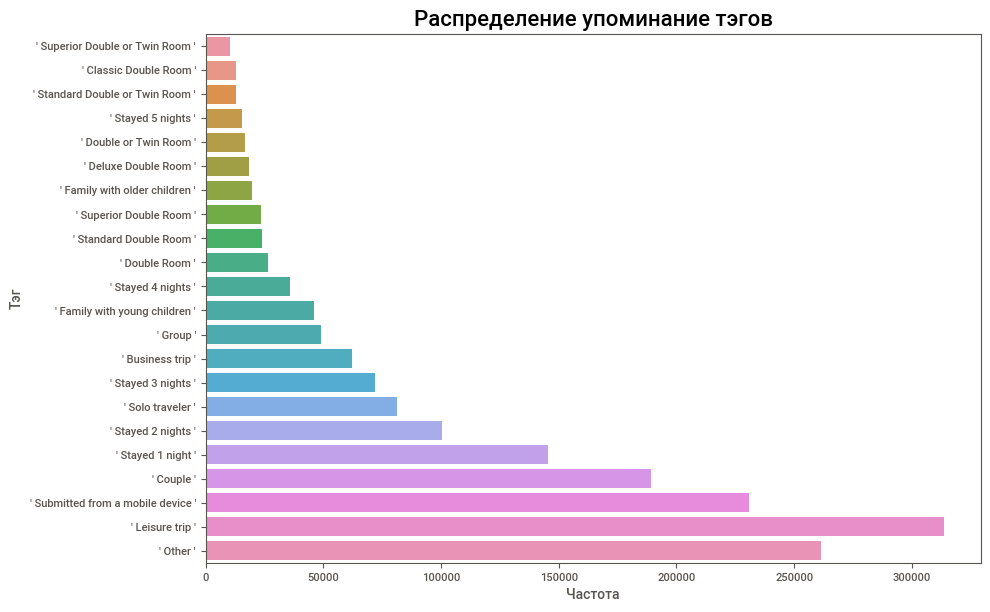

In [ ]:
# визуализируем частоту упоминания тегов
fig = plt.figure(figsize=(10, 7))
bar = sns.barplot(
    data=df1,
    y='tag',
    x='freq'
)
bar.set_title('Распределение упоминание тэгов',fontsize=16)
bar.set_xlabel('Частота')
bar.set_ylabel('Тэг')

In [ ]:
# список тэгов
tag_cols = list(df1['tag'])  

def get_tag_cols(x):
    """
    Функция создает новые бинарные признаки упоминания тэгами
    Args:
        x: строка столбца 'tags'.

    Returns:
        new_x: новай бинарный признак
    """
    x = x[1:]
    x = x[:-1]
    x = x.split(', ')
    new_x = ''
    for tag in x:
        if tag in tag_cols:
            new_x = new_x + ' ' + tag
        else:
            new_x = new_x + " ' Other '"
    return new_x

# преобразуем строку с тэгами в новую
hotels['tags_upd'] = hotels['tags'].apply(get_tag_cols)

# создаем бинарные новые призанки упоминая тэгов
for tag in tag_cols:
    tag = tag[2:]
    tag = tag[:-2]
    hotels[tag] = hotels['tags_upd'].apply(lambda x: 1 if tag in x else 0)

# удаляем признаки с "неразделенными" тэгами  
hotels.drop(['tags', 'tags_upd'], inplace=True, axis=1)

###3.3.2 Преобразование признака "Страна рецензента"
Создадим новые бинарные призанки страны рецензента из прзнака ***'reviewer_nationality'***, выделив 10 самыx популярныx стран, остальных отметив как 'other'. Затем закодируем признак методом **BinaryEncoder**

*Примечание:*  Выбираем первые 10 стран, т.к. по по предварительному анализу Sweetviz их частота 2% и более.

Text(0.5, 1.0, 'Распределение стран рецензентов')

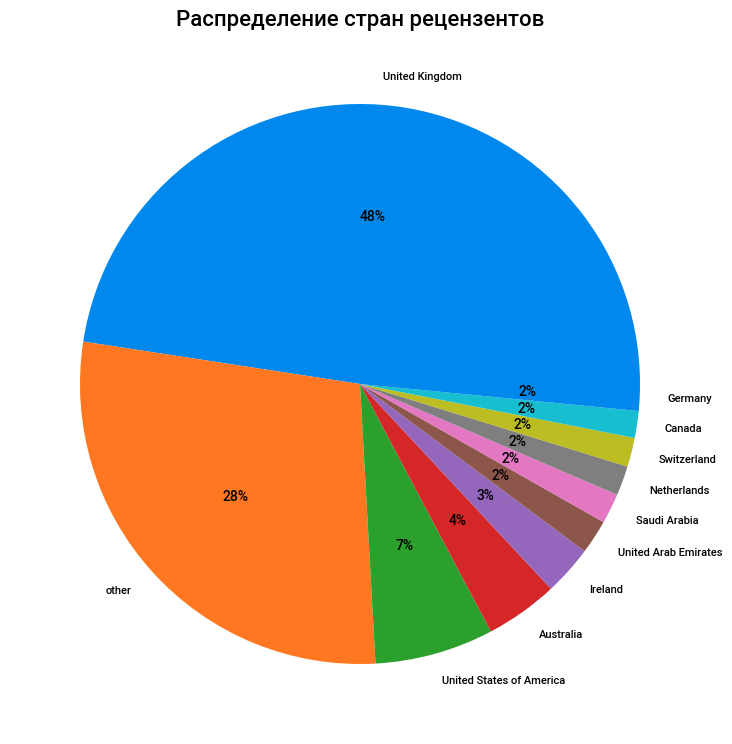

In [ ]:
# создаем список популярных стран
popular_country=['United Kingdom', 
                 'United States of America', 
                 'Australia', 
                 'Ireland', 
                 'United Arab Emirates',
                 'Saudi Arabia',
                 'Netherlands',
                 'Canada',
                 'Germany',
                 'Switzerland']

# удалим начальные и конечные пробелы
hotels['reviewer_nationality']=hotels['reviewer_nationality'].str.strip()

#создаем признак, заменив "непопулярные" страны на 'other'                
hotels['rev_country_by_coding']=hotels['reviewer_nationality'].apply(
    lambda x: 'other' if x not in popular_country else x)

# визуализируем распределение рецензентов по странам
rev_country_count = hotels['rev_country_by_coding'].value_counts()
fig = plt.figure(figsize=(7, 7))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    rev_country_count,
    labels=rev_country_count.index,
    autopct='%.0f%%'
);
axes.set_title('Распределение стран рецензентов', fontsize=16)

In [ ]:
#кодируем признак
encoder = ce.BinaryEncoder(cols=['rev_country_by_coding']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['rev_country_by_coding'])
hotels = pd.concat([hotels, type_bin], axis=1)

### 3.3.3 Преобразование признаков "Положительный отзыв" и "Отрицательный отзыв"
Используя возможности библиотеки NaturalLanguage ToolKit, преобразуем признаки отзывов positive_review и 'negative_review' в численные значения



In [ ]:
sent_analyzer = SentimentIntensityAnalyzer()

# приведем строки к нижнему регистру и удалим начальные и конечные пробелы
hotels['positive_review']=hotels['positive_review'].str.lower().str.strip()
hotels['negative_review']=hotels['negative_review'].str.lower().str.strip()

# преобразуем признаки отзыва в их количественную оценку
hotels['positive_review']=hotels['positive_review'].apply(lambda x: 
                            sent_analyzer.polarity_scores(x)['compound'])
hotels['negative_review']=hotels['negative_review'].apply(lambda x: 
                            sent_analyzer.polarity_scores(x)['compound'])

Text(0.5, 1.0, 'Распределение отрицательных отзывов')

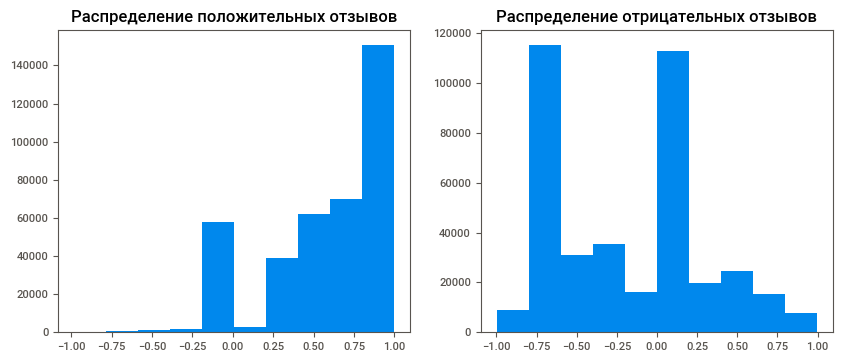

In [ ]:
#визуализируем распределение полученных признаков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].hist(x=hotels['positive_review'])
axes[0].set_title('Распределение положительных отзывов')

axes[1].hist(x=hotels['negative_review'])
axes[1].set_title('Распределение отрицательных отзывов')

Распределение признаков отличное от нормального. Разброс значений от -1 до 1 - нормализировать признаки не требуется.

## 3.4 Работа с признаком "Дата отзыва"
Преобразуем тип признака ***review_date*** в тип datetime и выделим из признака месяц, в котором оставлен отзыв.

In [ ]:
#приведем признак к типу datetime
hotels['review_date']=pd.to_datetime(hotels['review_date'])

print('Первый отзыв от', hotels['review_date'].min())
print('Пocледний отзыв от', hotels['review_date'].max())

#выделяем месяц из даты
hotels['month_rev']=hotels['review_date'].dt.month

hotels.drop('review_date', axis = 1, inplace=True)

Первый отзыв от 2015-08-04 00:00:00
Пocледний отзыв от 2017-08-03 00:00:00


## 3.5 Создание признака на основе данных из внешних 

Создадим признак 'population' - население страны рецензента. 

Примечание: За основу взят датасет, представленный в модуле курса "EDA-3. Проектирование признаков", и дополнен информацией по странам, которые в нем отсутсвовали.


In [ ]:
# создаем DataFrame
population_country=pd.read_csv('data/country_population.csv', sep=';')

# удалим начальные и конечные пробелы
hotels['reviewer_nationality']=hotels['reviewer_nationality'].str.strip()

# объединяем таблицы
hotels=hotels.merge(
    population_country,
    left_on='reviewer_nationality',
    right_on='country',
    how='left'  
)
hotels.drop('country', axis = 1, inplace=True)


In [ ]:
a=hotels['population'].isnull().sum()
print(f'Количество пропусков в признаке {a}')

Количество пропусков в признаке 395


In [ ]:
# заполняем пропуски
values={'population': hotels['population'].mode()[0]}
hotels=hotels.fillna(values)

In [ ]:
# убираем признаки object, которые еще не удалили
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

In [ ]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 0 to 386802
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               386803 non-null  float64
 1   negative_review                             386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  float64
 3   total_number_of_reviews                     386803 non-null  float64
 4   positive_review                             386803 non-null  float64
 5   review_total_positive_word_counts           386803 non-null  float64
 6   total_number_of_reviews_reviewer_has_given  386803 non-null  float64
 7   reviewer_score                              386803 non-null  float64
 8   days_since_review                           386803 non-null  float64
 9   lng                                         386803 non-null  float64
 

# 4. **Модель**

In [ ]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [ ]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [ ]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12516995236233558


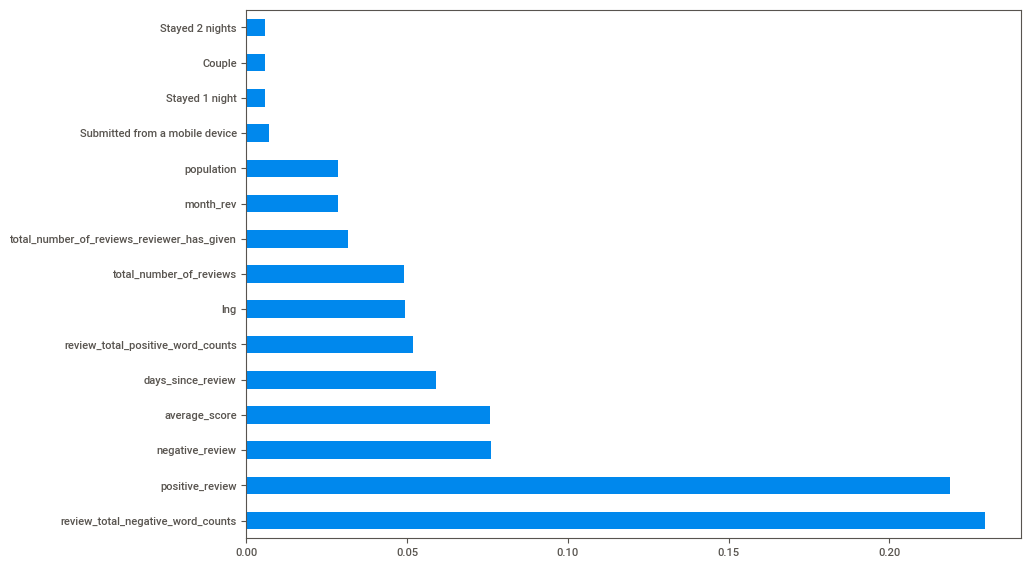

In [ ]:
# выведем самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,7)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')